In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt
# import GPy
import heatmap

data = xr.open_dataset("data/delhi_cpcb_2022.nc")
# data = xr.open_dataset("delhi_cpcb_2022.nc")
# data = pd.read_csv("../data/final_data.csv.gz")
data

<xarray.Dataset>
Dimensions:    (station: 40, time: 8783)
Coordinates:
  * station    (station) object 'Alipur, Delhi - DPCC' ... 'Wazirpur, Delhi -...
  * time       (time) datetime64[ns] 2022-01-01T00:30:00 ... 2023-01-01T22:23:30
    latitude   (station) float64 ...
    longitude  (station) float64 ...
Data variables: (12/21)
    From Date  (station, time) datetime64[ns] ...
    To Date    (station, time) datetime64[ns] ...
    PM2.5      (station, time) float64 ...
    PM10       (station, time) float64 ...
    NO         (station, time) float64 ...
    NO2        (station, time) float64 ...
    ...         ...
    WD         (station, time) float64 ...
    SR         (station, time) float64 ...
    BP         (station, time) float64 ...
    AT         (station, time) float64 ...
    RF         (station, time) float64 ...
    TOT-RF     (station, time) float64 ...

In [2]:
df_ = data.to_dataframe().reset_index()
# df_ = 
df = df_[df_["time"]=="2022-03-01 01:30:00"]
df = df.dropna(subset=["PM2.5"])
df = df.rename(columns={"RH": "relative_humidity", "WS": "wind_speed", "WD": "wind_direction", "SR": "solar_radiation", "BP": "pressure", "AT": "temperature", "RF": "rain_fall", "TOT-RF": "total_rainfall"})

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

def lr(X_train, y_train, X_test):

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    pred_y = lr.predict(X_test)
    
    return pred_y

2022-01-01 00:30:00	78.35049857527594


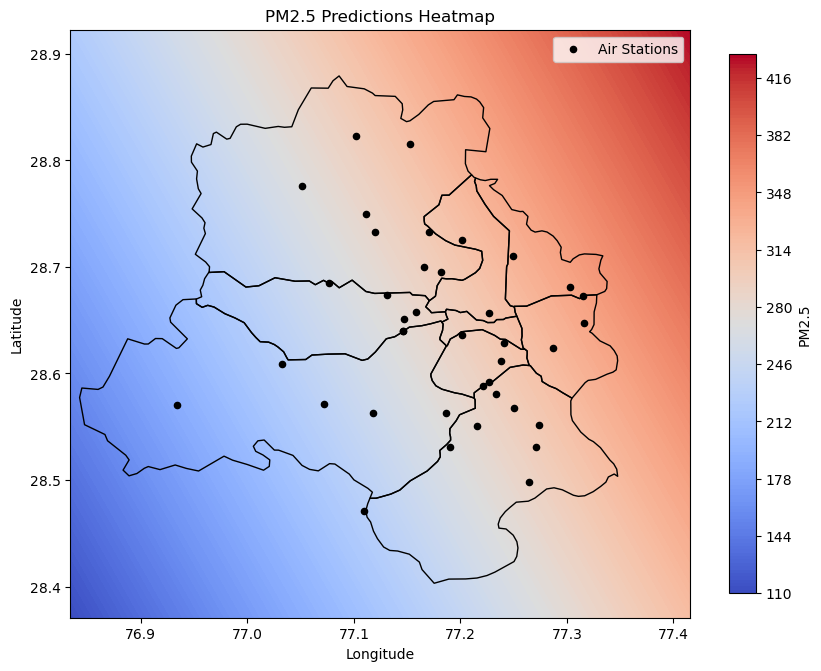

2022-02-01 00:30:00	46.289827972585734


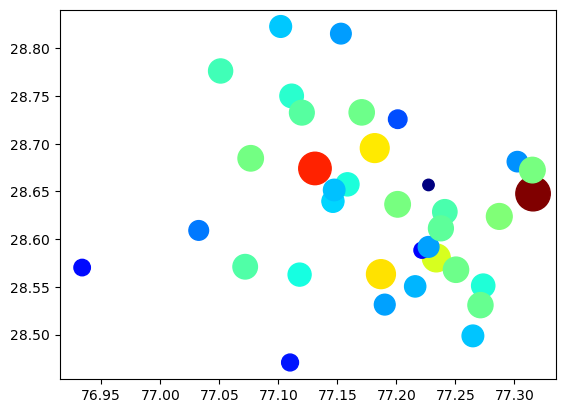

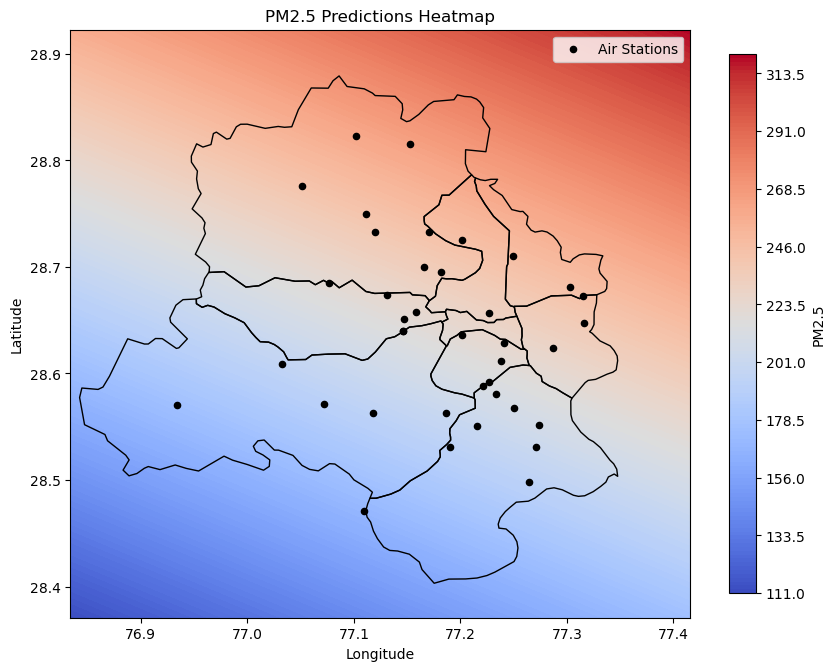

2022-03-01 00:30:00	25.973797203169575


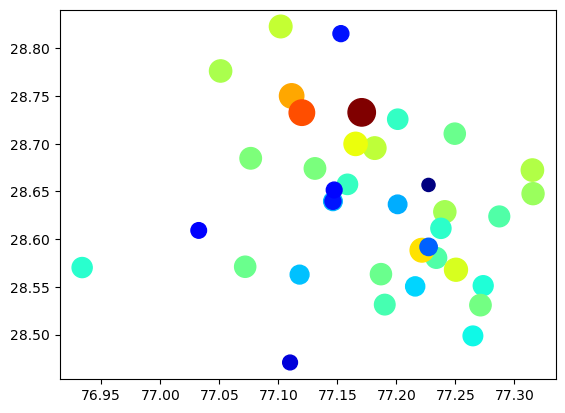

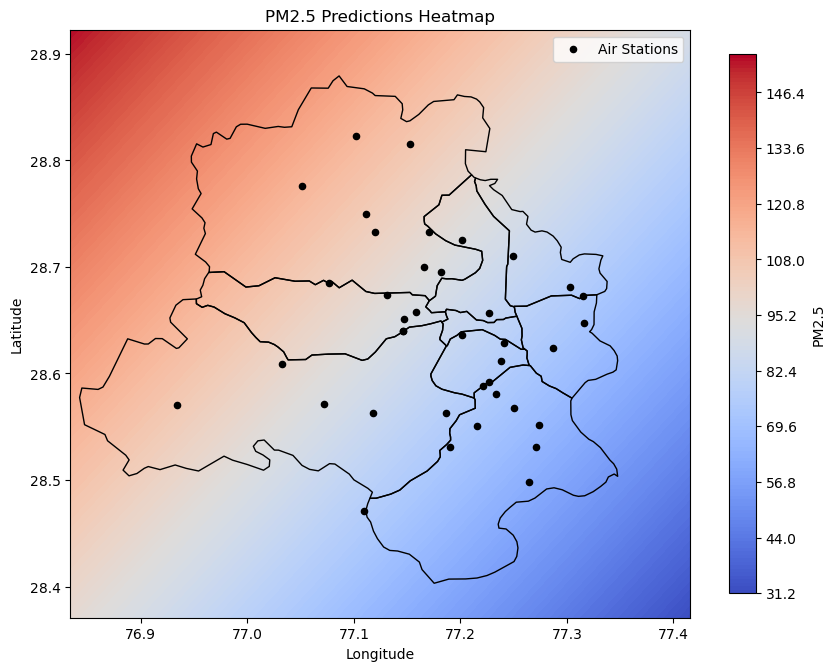

2022-04-01 00:30:00	30.579961741675504


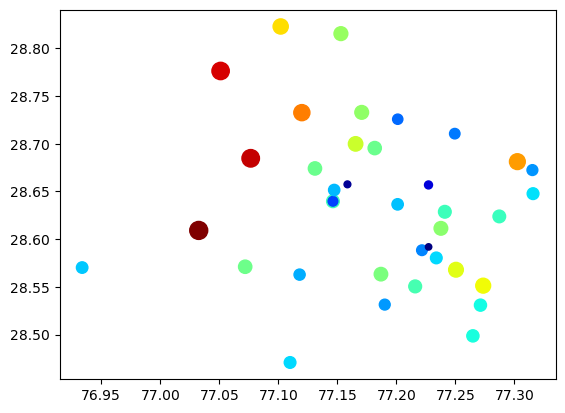

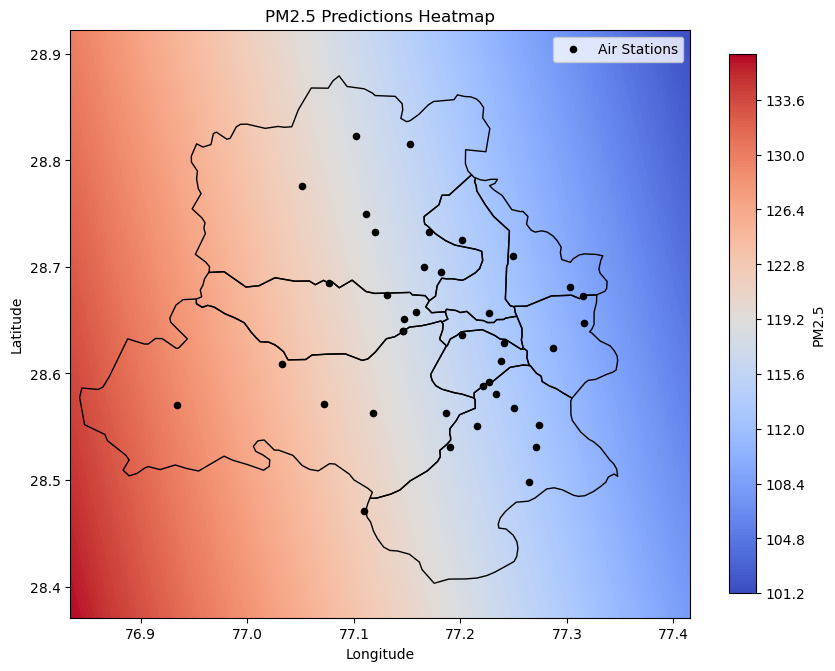

2022-05-01 00:30:00	44.17882082994075


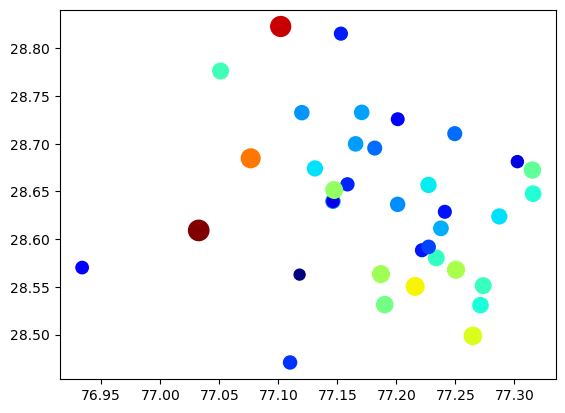

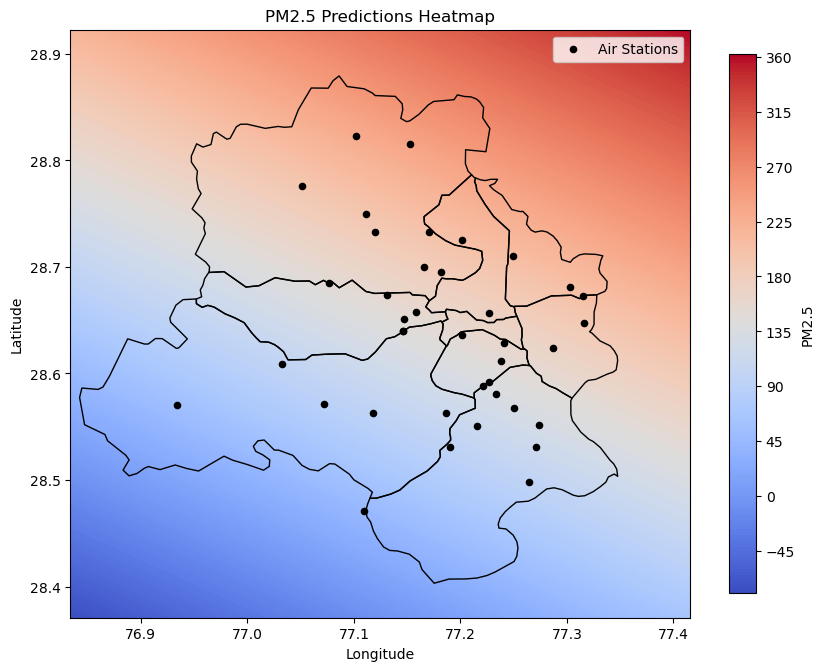

2022-06-01 00:30:00	35.36981244913026


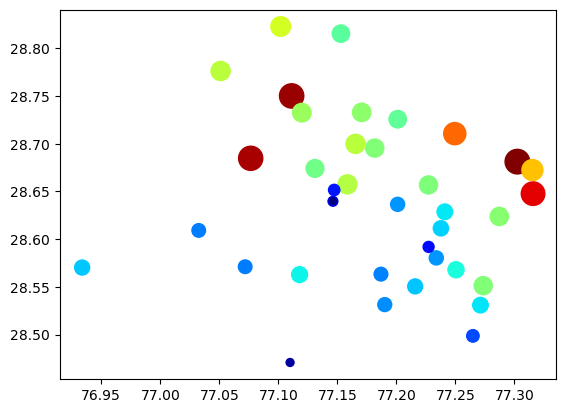

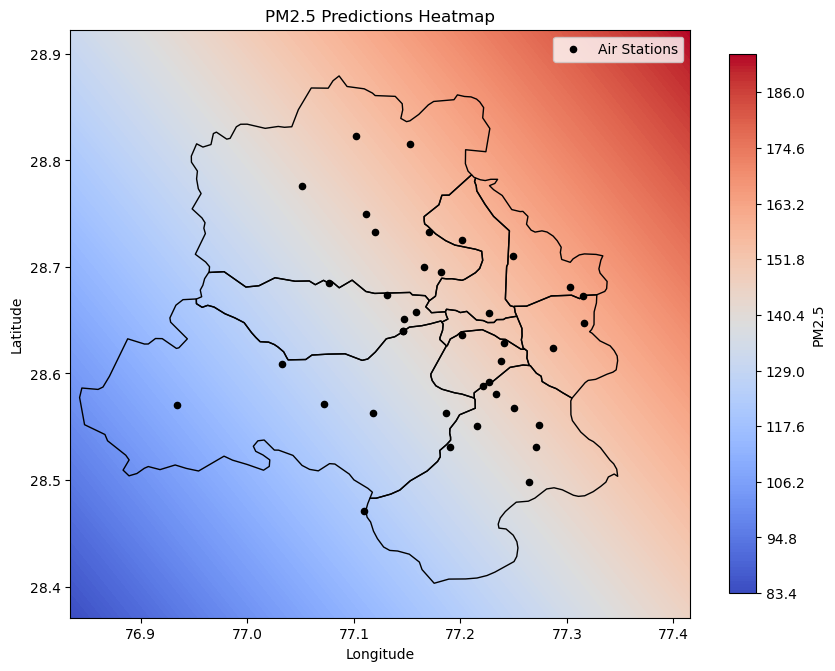

2022-07-01 00:30:00	7.517078840732147


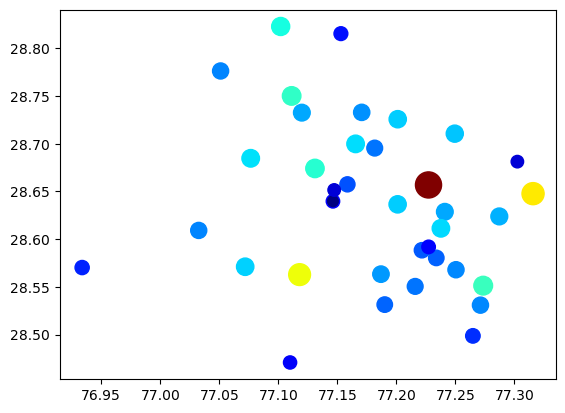

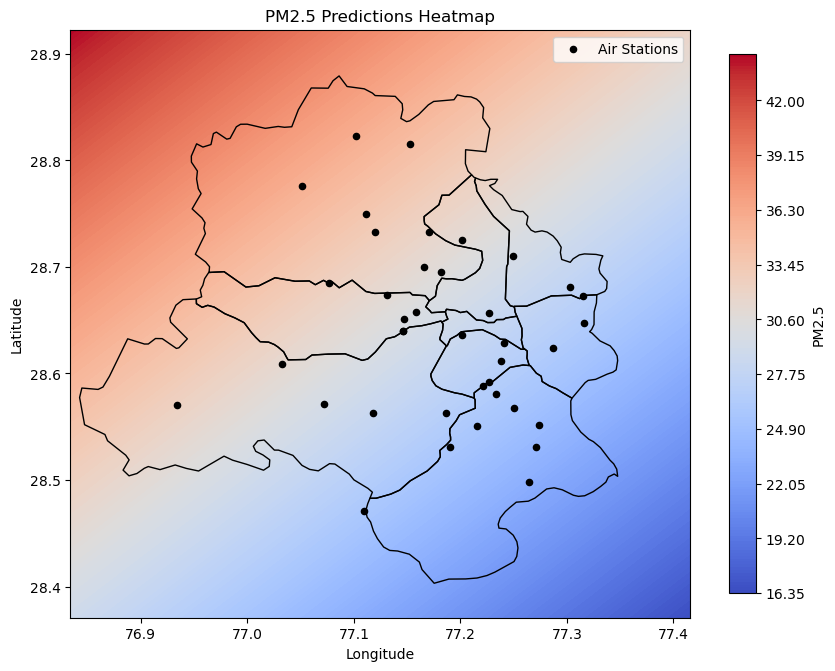

2022-08-01 00:30:00	16.262506942087917


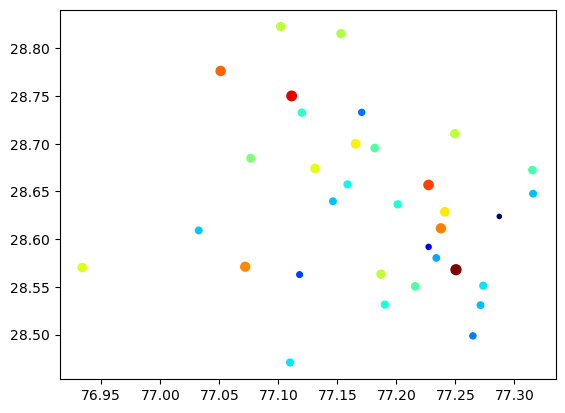

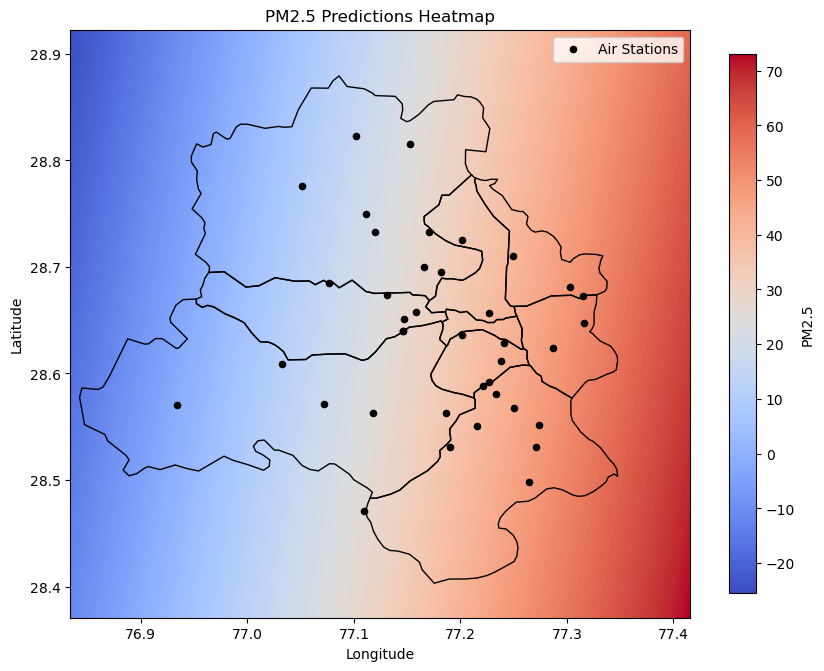

2022-09-01 00:30:00	13.176778886479054


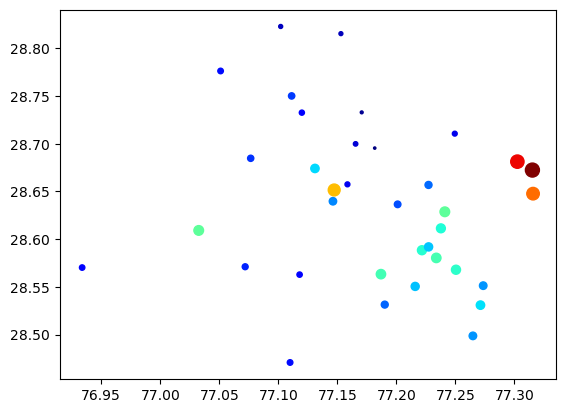

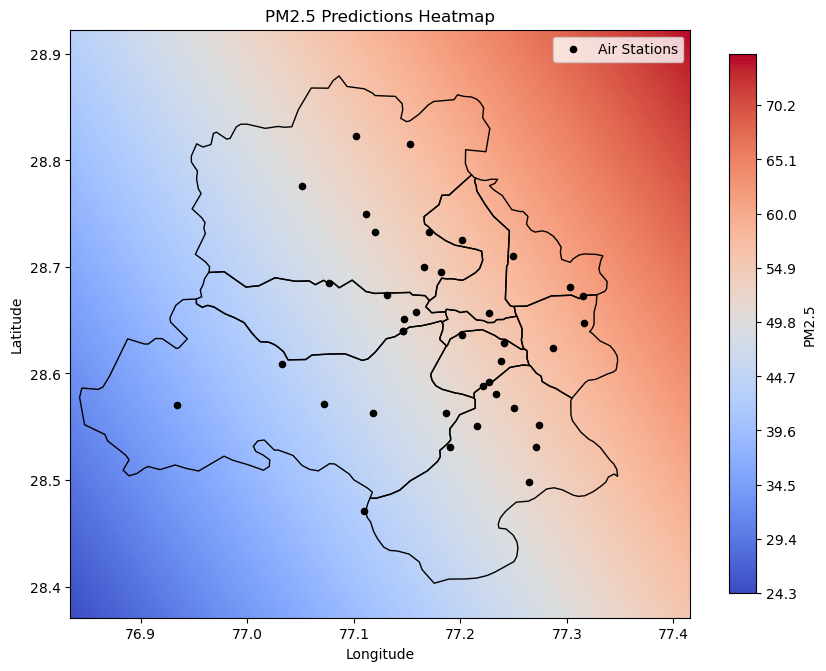

2022-10-01 00:30:00	20.95723881313744


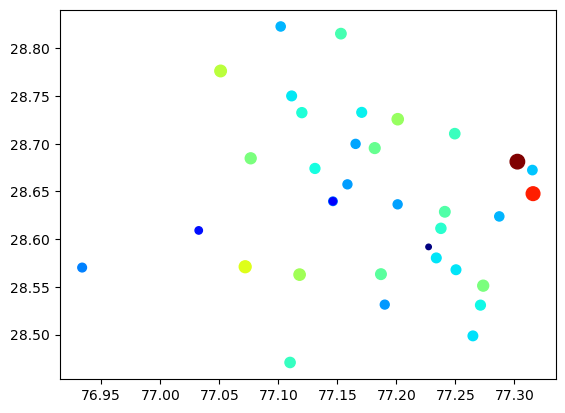

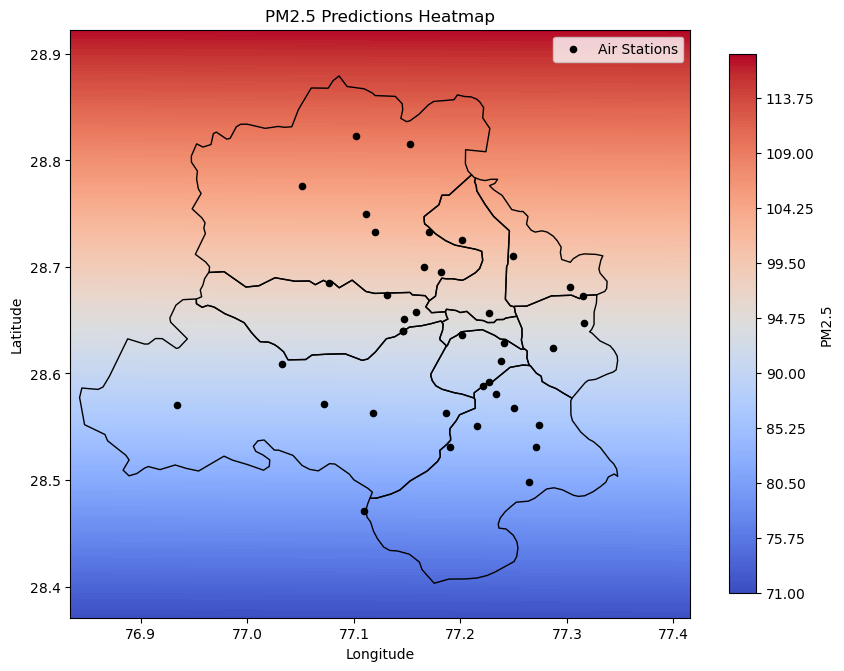

2022-11-01 00:30:00	90.5113613022892


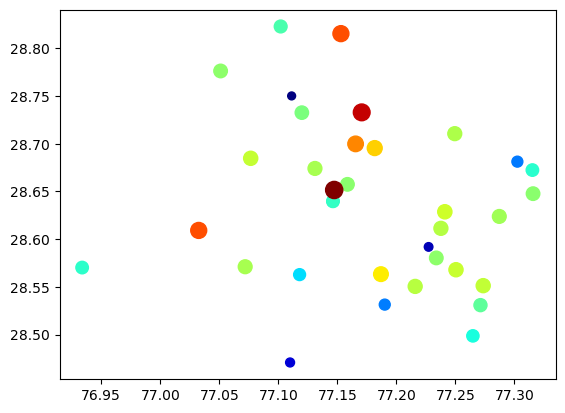

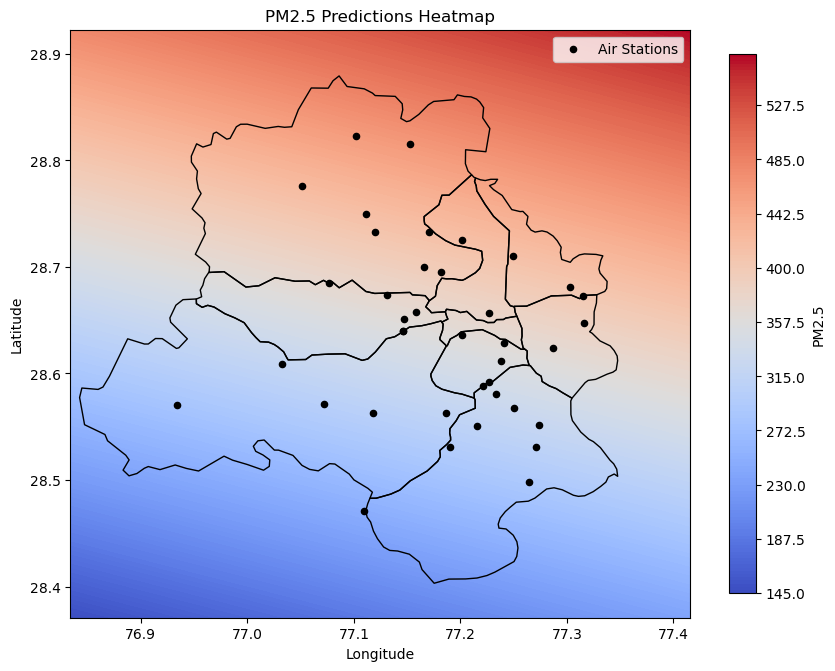

2022-12-01 00:30:00	49.804545650408066


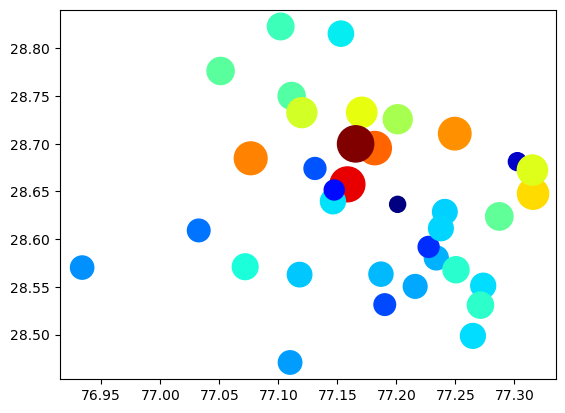

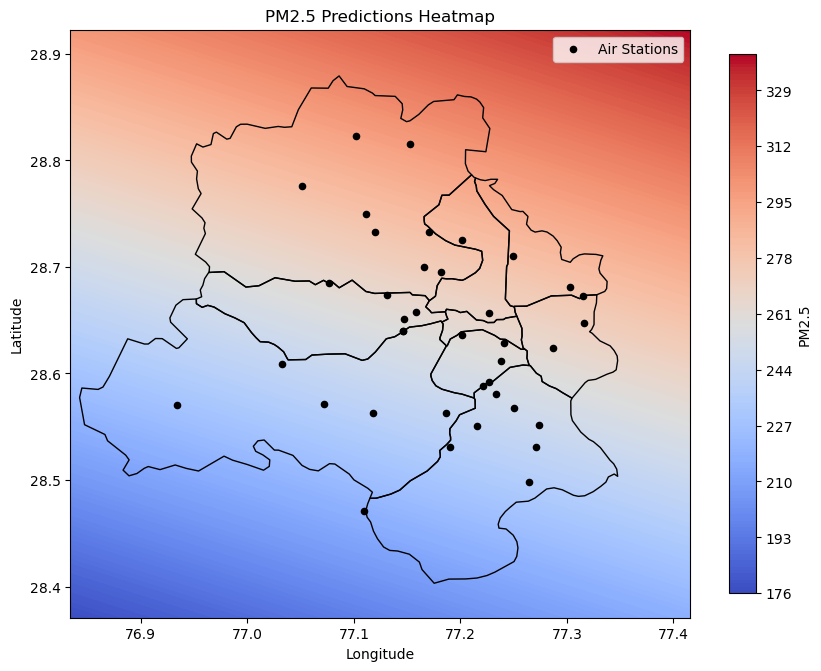

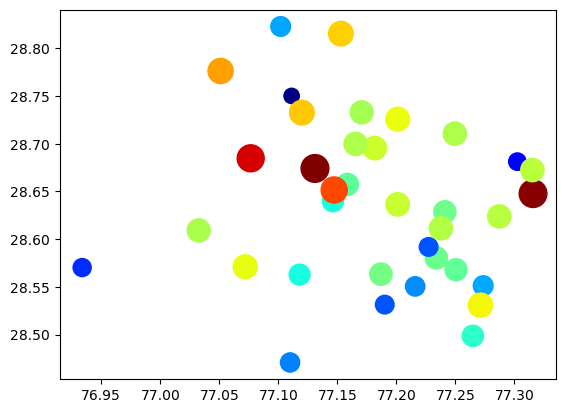

In [4]:
p = pd.date_range(start='2022-01-01 00:30:00', end='2022-12-01 00:30:00', freq = '1MS').to_frame(name='dates')
lr_rmse = []
lr_preds = []

for i in p['dates']:
    df = df_[df_["time"]==i]
    df = df.dropna(subset=["PM2.5"])
    print(i, end = '\t')
    lr_rmse_i = []
    
    #Leave One Out Cross Validation
    for station in df.station.unique():
        train = df[df['station'] != station]
        test = df[df['station'] == station]
        X_train = train[['latitude', 'longitude']]
        X_test = test[['latitude', 'longitude']]
        y_train = train['PM2.5']
        y_test = test['PM2.5']
        pred = lr(X_train, y_train, X_test)
        lr_rmse_i.append(np.sqrt((y_test - pred)**2))
    
    #RMSE
    lr_rmse.append(np.mean(lr_rmse_i))
    print(lr_rmse[-1])
    
    #Heatmap
    latitudes = np.array(df['latitude'])
    longitudes = np.array(df['longitude'])
    g_lat = np.linspace(latitudes.min()-0.1, latitudes.max()+0.1, 30)
    g_long = np.linspace(longitudes.min()-0.1, longitudes.max()+0.1, 30)
    lat_grid, lon_grid = np.meshgrid(g_lat, g_long)
    
    train = df[['latitude', 'longitude', 'PM2.5']]
    test = pd.DataFrame({'longitude':lon_grid.flatten(),
                     'latitude':lat_grid.flatten()})
    
    X_train = train[['latitude', 'longitude']]
    y_train = train['PM2.5']
    X_test = test[['latitude', 'longitude']]
    
    preds = lr(X_train, y_train, X_test)
    test['PM2.5'] = preds
    heatmap.plot_heatmap(lon = np.array(test['longitude']), lat = np.array(test['latitude']), values = test['PM2.5'].values)
    plt.scatter(df['longitude'], df['latitude'], c = df['PM2.5'], s = df['PM2.5'],cmap = 'jet')

In [5]:
lr_rmse

[78.35049857527594,
 46.289827972585734,
 25.973797203169575,
 30.579961741675504,
 44.17882082994075,
 35.36981244913026,
 7.517078840732147,
 16.262506942087917,
 13.176778886479054,
 20.95723881313744,
 90.5113613022892,
 49.804545650408066]